# EE5024 PA3: Dimensionality reduction of HoG features for Bayesian classification

* To develop Histogram of Oriented Gradients (HOG) descriptor based Human and non-human classification.
* Do dimensionality reduction to the HOG features using :
    * Principal Component Analysis (PCA)
    * Fischer Linear Discriminant (FLD)
* Finally classify the images as human and non-human from the reduced dimensional data using bayesian classification.

## Algorithm Overview
1. Dataset consists of human and horse classes.
2. Reshape the images in the datset uploaded to $256\times256$ and divide the images into $16\times16$ blocks.
3. Get the 9 bin HOG Descriptor (consider magnitude while binning) for all the blocks such that final HOG feature vector dimension will be $2304\times1$.
4. Visualize HoG and report one result per class using inbuilt function
5. Applying PCA:
    * Select top k eigen values such that $95\%$ energy is retained.
    * Note down the reduced dimension of HOG feature vector dimension.
6. Applying FLD:
    * Apply FLD to the HOG feature vector such that it’s reduced to one dimension.
    * Plot the magnitude of data points with different colors for both classes.
7. Apply bayesian classification seperately for data points from PCA and FLD.
8. Plot confusion matrix for the above and calculate the accuracy.

### Load the Human-Horse dataset
The data is loaded using `dataset.py` module, which reads the data images using *OpenCV* and resizes them to $256\times256$.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import cv2
import os
from dataset import load_dataset, preprocess
from numpy.linalg import norm
from bayes import bayesian_classifier

# load the datasets
train_data, train_labels = load_dataset('./human_horse_dataset/train')
test_data, test_labels = load_dataset('./human_horse_dataset/test')

print("original data dims------------------------------")
print("Train data: {}".format(train_data.shape))
print("Train labels: {}".format(train_labels.shape))
print("Test data: {}".format(test_data.shape))
print("Test labels: {}\n".format(test_labels.shape))

original data dims------------------------------
Train data: (1027,)
Train labels: (1027, 1)
Test data: (256,)
Test labels: (256, 1)



### Applying HoG
Here the 9 bin HOG Descriptor is applied to the images having $16\times16$ blocks each. This results in final feature vector dimension of $2304\times1$ (i.e. $16\times16\times9$).

In [21]:
# apply hog
def hog(img):
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
    mag, ang = cv2.cartToPolar(gx, gy)
    bin_n = 9 # Number of bins
    bin = np.int32(bin_n*ang/(2*np.pi))

    bin_cells = []
    mag_cells = []

    cellx = celly = 16

    for i in range(0,int(img.shape[0]/celly)):
        for j in range(0,int(img.shape[1]/cellx)):
            bin_cells.append(bin[i*celly : i*celly+celly, j*cellx : j*cellx+cellx])
            mag_cells.append(mag[i*celly : i*celly+celly, j*cellx : j*cellx+cellx])

    hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
    hist = np.hstack(hists)
    hist /= norm(hist)

    return hist

hog_train = []
for image in train_data:
    hist=hog(image)
    hog_train.append(hist)
train_data = np.array(hog_train)

hog_test = []
for image in test_data:
    hist=hog(image)
    hog_test.append(hist)
test_data = np.array(hog_test)

print("HoG dims----------------------------------------_")
print("Train data: {}".format(train_data.shape))
print("Train labels: {}".format(train_labels.shape))
print("Test data: {}".format(test_data.shape))
print("Test labels: {}\n".format(test_labels.shape))

HoG dims----------------------------------------_
Train data: (1027, 2304)
Train labels: (1027, 1)
Test data: (256, 2304)
Test labels: (256, 1)



Visualize HoG

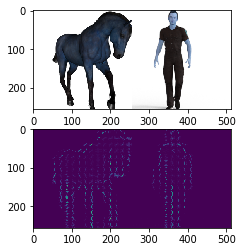

In [22]:
from skimage import feature

class_horse_img=preprocess(cv2.imread("human_horse_dataset/test/horses/horse1-000.png"))
(H, hog_class_horse_img) = feature.hog(class_horse_img, orientations=9, pixels_per_cell=(16,16),
	cells_per_block=(1, 1), transform_sqrt=True, block_norm="L1",visualize=True)

class_human_img=preprocess(cv2.imread("human_horse_dataset/test/humans/valhuman01-00.png"))
(H, hog_class_human_img) = feature.hog(class_human_img, orientations=9, pixels_per_cell=(16,16),
	cells_per_block=(1, 1), transform_sqrt=True, block_norm="L1",visualize=True)

# plt.imshow(np.hstack((class_horse_img,class_human_img)))
im1=np.hstack((class_horse_img,class_human_img))
im2=np.hstack((hog_class_horse_img,hog_class_human_img))
# plt.imshow(im1)
# plt.show()

fig = plt.figure()
plt.subplot(211)
plt.imshow(im1)
plt.subplot(212)
plt.imshow(im2)
plt.show()
fig.savefig('hog_visualization.jpg',dpi=500)

### Applying PCA for dimensionality reduction

In [23]:
# apply pca
from models import pca
train_len = train_data.shape[0]
data = np.vstack((train_data, test_data))
data_, _ = pca(data)
train_data_ = data_[:train_len]
test_data_ = data_[train_len:]

print("PCA dims-----------------------------------------")
print("Train data: {}".format(train_data_.shape))
print("Train labels: {}".format(train_labels.ravel().shape))
print("Test data: {}".format(test_data_.shape))
print("Test labels: {}\n".format(test_labels.ravel().shape))

PCA dims-----------------------------------------
Train data: (1027, 530)
Train labels: (1027,)
Test data: (256, 530)
Test labels: (256,)



Bayesian classification and confusion matrix

In [24]:
# apply bayesian_classifier
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
y_pred = model.fit(train_data_, train_labels.ravel().astype('int')).predict(test_data_)

# print(model.fit(train_data, train_labels.ravel().astype('int')).predict(test_data))
# print(test_labels.ravel())
print("Accuracy: {}".format((test_labels.ravel() == y_pred).sum() / test_data_.shape[0]))
from sklearn.metrics import confusion_matrix
confusion_matrix(test_labels.ravel().astype('int'), y_pred)


Accuracy: 0.921875


array([[116,  12],
       [  8, 120]])

### Applying Fischer Linear Discriminant for Dimensionality reduction 

In [25]:
x_ = np.concatenate([np.ones([train_data.shape[0], 1]), train_data], axis = 1)

n0,n1 = 0,0
M0,M1 = 0,0
weights = {}

class0, class1 = [], []
for i in range(train_data.shape[0]):
    if(train_labels[i]==0):
        M0 += x_[i]
        n0 += 1
        class0.append(x_[i])
    else:
        M1 += x_[i]
        n1 += 1
        class1.append(x_[i])
        
class0, class1 = np.array(class0), np.array(class1)        
M0 = M0/n0
M1 = M1/n1
M = np.mean(x_)

a0, a1 = class0 - M0, class1 - M1
S0 = np.dot(a0.T, a0)
S1 = np.dot(a1.T, a1)
SW = S0 + S1

SB = 0
m0 = M0.reshape(-1,1) - M.reshape(-1,1)
m0 = np.dot(m0, m0.T)
m0 = len(class0)*m0
SB+=m0
m1 = M1.reshape(-1,1) - M.reshape(-1,1)
m1 = np.dot(m1, m1.T)
m1 = len(class1)*m1
SB+=m1

print(SW.shape, SB.shape)

(2305, 2305) (2305, 2305)


In [26]:
reduced_dim = 2
w = np.dot(np.linalg.pinv(SW), SB)
eigenvalues, eigenvectors = np.linalg.eig(w)

Bayesian classification and confusion matrix

In [27]:
indices = eigenvalues.argsort()[::-1]
trans = eigenvectors[:, indices[0:reduced_dim]]
train_trans = abs(np.dot(x_, trans))
test_aug = np.concatenate([np.ones([test_data.shape[0], 1]), test_data], axis = 1) 
test_trans = abs(np.dot(test_aug, trans))

print(train_trans.shape, test_trans.shape)

model = GaussianNB()
y_pred = model.fit(train_trans, train_labels.ravel().astype('int')).predict(test_trans)
# print('Predicted Labels:', y_pred)
# print('Actual Labels:', test_labels.ravel())
print("Accuracy: {}".format((test_labels.ravel() == y_pred).sum() / test_data.shape[0]))
from sklearn.metrics import confusion_matrix
confusion_matrix(test_labels.ravel().astype('int'), y_pred)

(1027, 2) (256, 2)
Accuracy: 0.5703125


array([[92, 36],
       [74, 54]])

Plot the magnitude of data points with different colors for both classes

(500, 2) (527, 2)


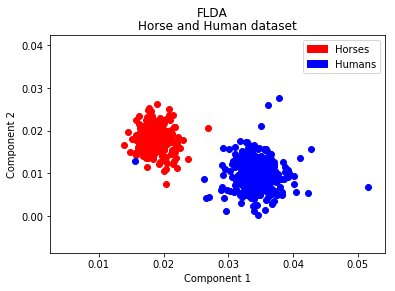

In [37]:
class0_ = []
class1_ = []
for i in range(train_len):
    if(train_labels[i]==0):
        class0_.append(train_trans[i])
    else:
        class1_.append(train_trans[i])
class0_, class1_ = np.array(class0_), np.array(class1_)
print(class0_.shape, class1_.shape)

fig = plt.figure()
plt.suptitle("FLDA")
plt.title("Horse and Human dataset")
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.scatter(class0_[:,0], class0_[:,1],color='r')
plt.scatter(class1_[:,0], class1_[:,1],color='b')

import matplotlib.patches as mpatches
pop_a = mpatches.Patch(color='r', label='Horses')
pop_b = mpatches.Patch(color='b', label='Humans')

plt.legend(handles=[pop_a,pop_b])
plt.show()
fig.savefig('flda_househorsedataset.jpg')

***
&copy; Aakash [nimrobotics.github.io](https://nimrobotics.github.io/)